In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path="/content/drive/MyDrive/毕设"
os.chdir(path)
os.listdir(path)

['MIT-BIH-360',
 '文档',
 '模型',
 '数据CNN_LSTM',
 'CNN_LSTM_ECG数据泄露_未来加smote.ipynb',
 'CNN',
 'biLSTM.ipynb',
 'LSTM.ipynb',
 'CNN_biLSTM五分类.ipynb',
 'CNN_LSTM最新.ipynb',
 'CNN_LSTM最新.ipynb（副本）',
 'CNN（副本）_最新',
 'CNN_试验随机性',
 'CNN_注意力机制',
 'CNN_LSTM再次试验随机性.ipynb',
 'biLSTM.ipynb（副本）',
 'CNN模型13',
 'CNN为了得到模型13',
 'CNN_池化层后添加注意力机制',
 'CNN_精进数据集_CNN_LSTM',
 '精进数据集_CNN_BiLSTMgpu_目前最高',
 'biLSTM.ipynb精进数据集',
 'CNN_CBAM精进数据集_后续需修改损失函数',
 'CNN_SENET_LSTM精进数据集',
 'CNN_精进数据集_CNN本身GPU',
 '精进数据集_CNN_BiLSTMgpu 30',
 'CNN_SENET精进数据集',
 'epoch=30 biLSTM.ipynb',
 'CNN_SENET_LSTM精进数据集_五折交叉验证.ipynb',
 'CNN_精进数据集_CNN本身GPU_五折交叉验证.ipynb',
 'epoch=30 biLSTM_画损失函数.ipynb',
 'CNN_SENET_LSTM精进数据集_画损失函数.ipynb',
 'CNN_精进数据集_CNN本身GPU_画损失函数.ipynb',
 'CNN_SENET精进数据集 epoch=30.ipynb',
 'CNN_精进数据集_CNN_做手脚的程序！',
 'CNN_SENET_LSTM精进数据集_提问chatgpt.ipynb',
 'CNN_精进数据集_CNN本身GPU_最终版本.ipynb',
 'resnet.ipynb']

In [ ]:
# pip install tensorflow-determinism
# tensorflow-determinism = 0.3.0
# tensorflow = 2.9.1
#设置随机种子
import random
import numpy as np
import tensorflow as tf

random_seed = 42
random.seed(random_seed )  # set random seed for python
np.random.seed(random_seed )  # set random seed for numpy
tf.random.set_seed(random_seed )  # set random seed for tensorflow-cpu
os.environ['TF_DETERMINISTIC_OPS'] = '1' # set random seed for tensorflow-gpu
os.environ['PYTHONHASHSEED'] = str(random_seed)

In [ ]:

# 检查GPU是否可用
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices available. Training on CPU.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Training on GPU.")

Training on GPU.


In [ ]:
!pip install tensorflow-determinism

In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 1.8 MB/s eta 0:00:00


In [ ]:
import wfdb
import pywt
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
#归一化
from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import roc_auc_score, roc_curve, auc
#from sklearn.metrics import auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras import layers, models

In [ ]:
# 测试集在数据集中所占的比例
#后续根据需求进行改正
RATIO = 0.2

In [ ]:
# 小波去噪预处理
def denoise(data):
    # 小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs
    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)
    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

In [ ]:
# 读取心电数据和对应标签,并对数据进行小波去噪
def getDataSet(number, X_data, Y_data):
    ecgClassSet = ['N', 'A', 'V', 'L', 'R']
    #ecgClassSet = ['N', 'A', 'V', 'L', 'R', '/', '!', 'E']
    # 读取心电数据记录
    print("正在读取 " + number + " 号心电数据...")
    # 读取MLII导联的数据, 这边路径换成自己的下载路径就行
    record = wfdb.rdrecord('/content/drive/MyDrive/毕设/MIT-BIH-360/' + number, channel_names=['MLII'])
    #record = wfdb.rdrecord('D:/大学/毕设/MIT-BIH-360/' + number, channel_names=['MLII', 'V1', 'V2', 'V4', 'V5'])
    #record = wfdb.rdrecord('D:/大学/毕设/MIT-BIH-360/' + number)
    data = record.p_signal.flatten()
    rdata = denoise(data=data)
    # 获取心电数据记录中R波的位置和对应的标签
    annotation = wfdb.rdann('/content/drive/MyDrive/毕设/MIT-BIH-360/' + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol
    # 去掉前后的不稳定数据
    start = 10
    end = 5
    i = start
    j = len(annotation.symbol) - end
    # 因为只选择NAVLR五种心电类型,所以要选出该条记录中所需要的那些带有特定标签的数据,舍弃其余标签的点
    # X_data在R波前后截取长度为300的数据点
    # Y_data将NAVLR按顺序转换为01234
    while i < j:
        try:
            # Rclass[i] 是标签
            lable = ecgClassSet.index(Rclass[i])
            # 基于经验值，基于R峰向前取100个点，向后取200个点
            x_train = rdata[Rlocation[i] - 100:Rlocation[i] + 200]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            i += 1
    return


In [ ]:

# 加载数据集并进行预处理
def loadData():
    numberSet =['100', '101', '103', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115',
               '116', '117','118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208','209',
               '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230',
               '231', '232', '233', '234']
    dataSet = []
    lableSet = []
    for n in numberSet:
        getDataSet(n, dataSet, lableSet)
    # 转numpy数组,打乱顺序
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)
    # 数据集及其标签集
    X = train_ds[:, :300].reshape(-1, 300, 1)
    Y = train_ds[:, 300]
    # 测试集及其标签集
    shuffle_index = np.random.permutation(len(X))
    # 设定测试集的大小 RATIO是测试集在数据集中所占的比例
    test_length = int(RATIO * len(shuffle_index))
    # 测试集的长度
    test_index = shuffle_index[:test_length]
    # 训练集的长度
    train_index = shuffle_index[test_length:]
    X_test, Y_test = X[test_index], Y[test_index]
    X_train, Y_train = X[train_index], Y[train_index]


    # 创建 MinMaxScaler 对象
    scaler = MinMaxScaler()
    print('开始归一化')
    # X_train对每个样本的特征进行归一化
    for i in range(X_train.shape[0]):
        X_train[i, :, :] = scaler.fit_transform(X_train[i, :, :])

    # X_test对 X_test 进行 Min-Max 归一化

    for j in range(X_test.shape[0]):
        X_test[j, :, :] = scaler.fit_transform(X_test[j, :, :])
    print('归一化结束')

    # 设定目标样本数量
    target_samples_per_class = 2000

    for class_label in range(5):  # 假设有5个类别
        # 找到当前类别的样本索引
        class_indices = np.where(Y_train == class_label)[0]

        # 随机抽样，获取多余的样本索引
        extra_indices = np.random.choice(class_indices, size=len(class_indices) - target_samples_per_class, replace=False)

        # 从X_train和Y_train中删除多余的样本
        X_train = np.delete(X_train, extra_indices, axis=0)
        Y_train = np.delete(Y_train, extra_indices, axis=0)


    target_samples_per_class_test = 500

    for class_label in range(5):  # 假设有5个类别
        # 找到当前类别的样本索引
        class_indices = np.where(Y_test == class_label)[0]

        # 随机抽样，获取多余的样本索引
        extra_indices = np.random.choice(class_indices, size=len(class_indices) - target_samples_per_class_test, replace=False)

        # 从X_train和Y_train中删除多余的样本
        X_test = np.delete(X_test, extra_indices, axis=0)
        Y_test = np.delete(Y_test, extra_indices, axis=0)
    return X_train, Y_train, X_test, Y_test



In [ ]:
# def plotHeatMap(Y_test, Y_pred):
#     con_mat = confusion_matrix(Y_test, Y_pred)
#     # 绘图
#     plt.figure(figsize=(4, 5))
#     seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
#     plt.ylim(0, 5)
#     plt.xlabel('Predicted labels')
#     plt.ylabel('True labels')
#     plt.show()
def plotHeatMap(Y_test, Y_pred, classes):
    #绘制混淆矩阵
    #绘图
    #plot(Y_test, Y_pred)
    con_mat = confusion_matrix(Y_test, Y_pred)
    plt.figure(figsize=(5, 5))
    seaborn.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [ ]:


# # 修改你的CNN模型
# def buildModel():
#     newModel = tf.keras.models.Sequential([
#         tf.keras.layers.Conv1D(filters=128, kernel_size=20, strides=3, padding='same', activation=tf.nn.relu, kernel_initializer='glorot_normal'),
#         tf.keras.layers.BatchNormalization(),

#         tf.keras.layers.MaxPool1D(pool_size=2, strides=3),
#         tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='same', activation=tf.nn.relu, kernel_initializer='glorot_normal'),
#         tf.keras.layers.BatchNormalization(),

#         tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
#         tf.keras.layers.Conv1D(filters=32, kernel_size=10, strides=1, padding='same', activation=tf.nn.relu, kernel_initializer='glorot_normal'),

#         tf.keras.layers.MaxPool1D(pool_size=2, strides=2),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dropout(rate=0.1),
#         #tf.keras.layers.Dense(units=20, activation=tf.nn.relu),
#         tf.keras.layers.Dense(units=10, activation=tf.nn.relu),
#         tf.keras.layers.Dense(units=5, activation=tf.nn.softmax)
#     ])
#     return newModel


def BasicBlock1D(filters, stride=1, downsample=None):
    def make_basic_block_model(inputs):
        x = layers.Conv1D(filters, kernel_size=7, strides=stride, padding='same', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Conv1D(filters, kernel_size=7, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        if downsample is not None:
            inputs = downsample(inputs)

        x = layers.add([x, inputs])
        x = layers.ReLU()(x)
        return x
    return make_basic_block_model

def make_layer(block, filters, blocks, stride=1, downsample_suffix=''):
    def make_layer_model(inputs):
        downsample = None
        if stride != 1:
            downsample = tf.keras.Sequential([
                layers.Conv1D(filters, kernel_size=1, strides=stride, use_bias=False),
                layers.BatchNormalization(),
            ], name=f"downsample_{downsample_suffix}")  # Unique name for each downsample layer

        x = block(filters, stride, downsample)(inputs)
        for _ in range(1, blocks):
            x = block(filters)(x)
        return x
    return make_layer_model

def buildModel():
    inputs = tf.keras.Input(shape=(300, 1))  # Adjusted the input shape to match your data
    x = layers.Conv1D(64, kernel_size=15, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    x = make_layer(BasicBlock1D, 64, 2, downsample_suffix='1')(x)
    x = make_layer(BasicBlock1D, 128, 2, stride=2, downsample_suffix='2')(x)
    x = make_layer(BasicBlock1D, 256, 2, stride=2, downsample_suffix='3')(x)
    x = make_layer(BasicBlock1D, 512, 2, stride=2, downsample_suffix='4')(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(5, activation='softmax')(x)  # For 5 output classes

    model = models.Model(inputs=inputs, outputs=x)
    return model


In [ ]:
def main():
    # X_train,Y_train为所有的数据集和标签集
    # X_test,Y_test为拆分的测试集和标签集
    global X_train, Y_train, X_test, Y_test, Y_pred_classes
    X_train, Y_train, X_test, Y_test = loadData()
    print(X_train.shape)

    model = buildModel()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', metrics=['accuracy']
                  # metrics: 列表，包含评估模型在训练和测试时的性能的指标，典型用法是metrics=[‘accuracy’]。
                  )
    # 在模型的 compile 和 fit 部分使用 custom_object_scope
    # with custom_object_scope({'FocalLoss': FocalLoss}):  # 注意这里使用 FocalLoss 类
    #     model.compile(optimizer='adam',
    #                   loss=FocalLoss(),  # 直接传入 FocalLoss 实例
    #                   metrics=['accuracy'])
    #model.summary()

    # 训练与验证
    #model.fit(X_train, Y_train, epochs=30, batch_size=128, validation_split=RATIO)  # validation_split 训练集所占比例
    history = model.fit(X_train, Y_train, epochs=30, batch_size=128, validation_split=RATIO)  # validation_split 训练集所占比例
    #model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_split=RATIO)  # validation_split 训练集所占比例
    # 预测
    Y_pred = model.predict(X_test)
    print(Y_pred)
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    #model.save('/content/drive/MyDrive/毕设/模型/model_saved_98')


    # 绘制训练集和验证集的损失函数图
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 计算并绘制多类别AUC-ROC曲线
    y_pred_proba = model.predict(X_test)
    n_classes = y_pred_proba.shape[1]

    # 将标签二值化
    y_test_bin = label_binarize(Y_test, classes=list(range(n_classes)))

    # 计算并绘制每个类别的 ROC 曲线
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    #混淆矩阵
    #注意数字
    #plotHeatMap(Y_test, Y_pred_classes, ['N', 'A', 'V', 'L', 'R'])

    # 绘制训练集和验证集的准确率曲线
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


正在读取 100 号心电数据...
正在读取 101 号心电数据...
正在读取 103 号心电数据...
正在读取 105 号心电数据...
正在读取 106 号心电数据...
正在读取 107 号心电数据...
正在读取 108 号心电数据...
正在读取 109 号心电数据...
正在读取 111 号心电数据...
正在读取 112 号心电数据...
正在读取 113 号心电数据...
正在读取 114 号心电数据...
正在读取 115 号心电数据...
正在读取 116 号心电数据...
正在读取 117 号心电数据...
正在读取 118 号心电数据...
正在读取 119 号心电数据...
正在读取 121 号心电数据...
正在读取 122 号心电数据...
正在读取 123 号心电数据...
正在读取 124 号心电数据...
正在读取 200 号心电数据...
正在读取 201 号心电数据...
正在读取 202 号心电数据...
正在读取 203 号心电数据...
正在读取 205 号心电数据...
正在读取 207 号心电数据...
正在读取 208 号心电数据...
正在读取 209 号心电数据...
正在读取 210 号心电数据...
正在读取 212 号心电数据...
正在读取 213 号心电数据...
正在读取 214 号心电数据...
正在读取 215 号心电数据...
正在读取 217 号心电数据...
正在读取 219 号心电数据...
正在读取 220 号心电数据...
正在读取 221 号心电数据...
正在读取 222 号心电数据...
正在读取 223 号心电数据...
正在读取 228 号心电数据...
正在读取 230 号心电数据...
正在读取 231 号心电数据...
正在读取 232 号心电数据...
正在读取 233 号心电数据...
正在读取 234 号心电数据...
开始归一化
归一化结束
(10000, 300, 1)
Epoch 1/30
63/63 [==============================] - 23s 91ms/step - loss: 0.6014 - accuracy: 0.7972 - val_loss: 1.9132 - val_accuracy: 0.2675
Ep

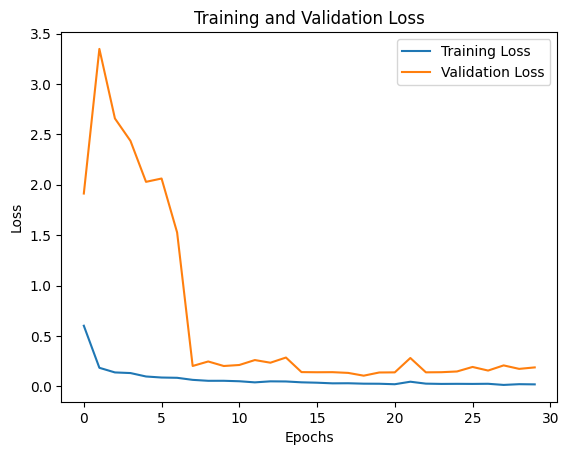

79/79 [==============================] - 1s 7ms/step


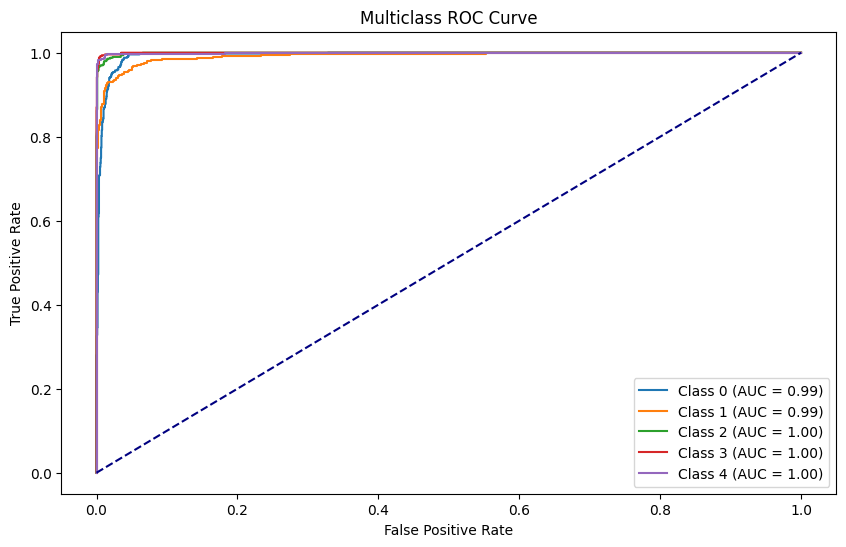

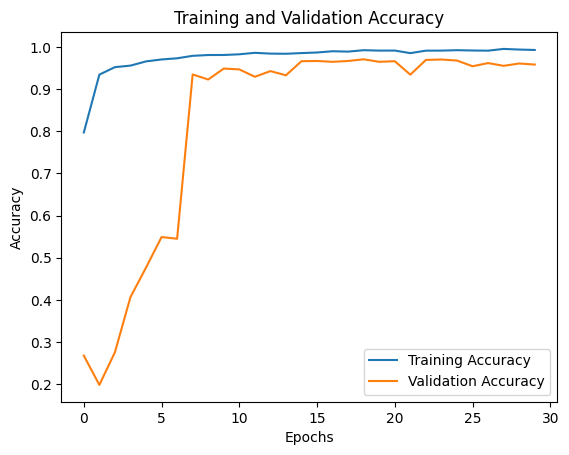

In [ ]:
if __name__ == '__main__':
    main()

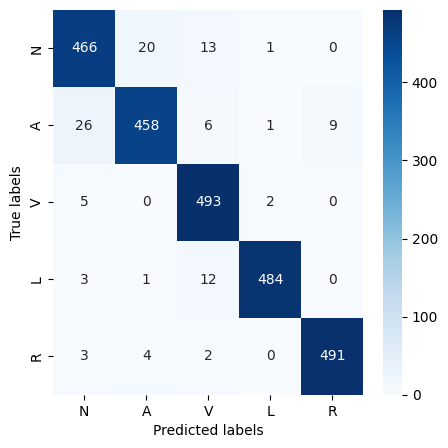

In [ ]:
plotHeatMap(Y_test, Y_pred_classes, ['N', 'A', 'V', 'L', 'R'])

In [ ]:
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(Y_test, Y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       500
         1.0       0.95      0.92      0.93       500
         2.0       0.94      0.99      0.96       500
         3.0       0.99      0.97      0.98       500
         4.0       0.98      0.98      0.98       500

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



In [ ]:
# # 使用np.unique统计每个类别的数量
# unique_classes, class_counts = np.unique(Y_test, return_counts=True)

# # unique_classes中存储了唯一的类别标签，class_counts中存储了每个类别的数量
# for class_label, count in zip(unique_classes, class_counts):
#     print(f"Class {class_label}: {count} samples")

In [ ]:
# 加载保存的模型
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/毕设/模型/model_saved_92')

predictions = loaded_model.predict(X_test)
Y_pred_classes = np.argmax(predictions, axis=1)
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(Y_test, Y_pred_classes))

79/79 [==============================] - 1s 12ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90       500
         1.0       0.99      0.83      0.90       500
         2.0       0.97      0.96      0.96       500
         3.0       0.97      0.99      0.98       500
         4.0       0.98      1.00      0.99       500

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



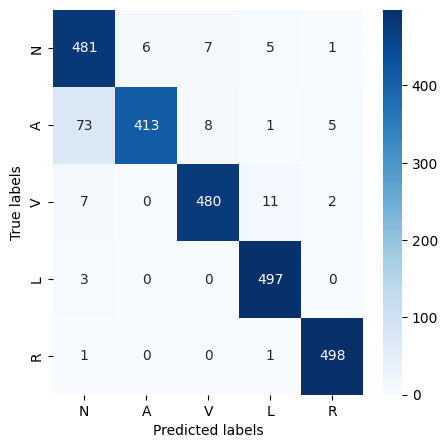

In [ ]:
plotHeatMap(Y_test, Y_pred_classes, ['N', 'A', 'V', 'L', 'R'])

In [ ]:
#CNN
# 加载保存的模型
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/毕设/模型/model_saved_71')

predictions = loaded_model.predict(X_test)
Y_pred_classes = np.argmax(predictions, axis=1)
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(Y_test, Y_pred_classes))

393/393 [==============================] - 2s 4ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      7637
         1.0       0.42      0.49      0.45       305
         2.0       0.99      0.91      0.95      1090
         3.0       1.00      0.99      0.99      3447
         4.0       1.00      0.98      0.99        81

    accuracy                           0.97     12560
   macro avg       0.88      0.87      0.87     12560
weighted avg       0.97      0.97      0.97     12560



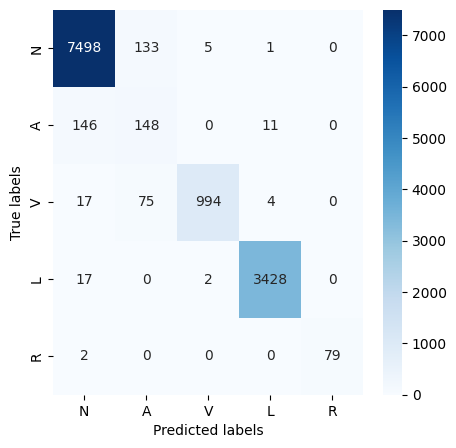

In [ ]:
plotHeatMap(Y_test, Y_pred_classes, ['N', 'A', 'V', 'L', 'R'])

In [ ]:
#CNN
# 加载保存的模型
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/毕设/模型/model_saved_31')

predictions = loaded_model.predict(X_test)
Y_pred_classes = np.argmax(predictions, axis=1)
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(Y_test, Y_pred_classes))

393/393 [==============================] - 4s 10ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      7637
         1.0       0.60      0.55      0.57       305
         2.0       0.99      0.89      0.94      1090
         3.0       1.00      1.00      1.00      3447
         4.0       1.00      0.96      0.98        81

    accuracy                           0.98     12560
   macro avg       0.91      0.88      0.90     12560
weighted avg       0.98      0.98      0.98     12560



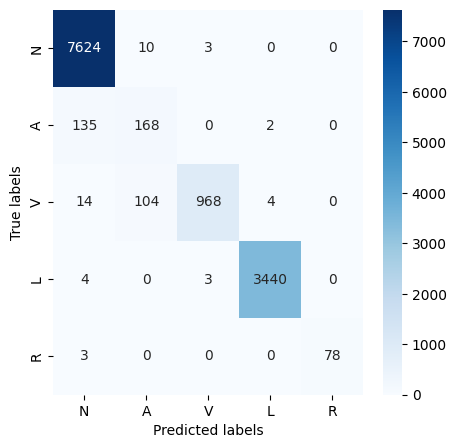

In [ ]:
plotHeatMap(Y_test, Y_pred_classes, ['N', 'A', 'V', 'L', 'R'])